@inproceedings{souza2020bertimbau,
  author    = {F{\'a}bio Souza and
               Rodrigo Nogueira and
               Roberto Lotufo},
  title     = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese},
  booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)},
  year      = {2020}
}


# **Conectando ao Google Drive**


Para acessar e carregar os dados necessários para o projeto, montamos o Google Drive. Isso permite que o notebook leia arquivos diretamente de uma pasta em sua conta, facilitando o gerenciamento e a persistência dos dados entre diferentes sessões. O comando a seguir solicita permissão para conectar o

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import evaluate
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
import torch
from torch.utils.data import Dataset as TorchDataset
import matplotlib.pyplot as plt
import sys
import subprocess
import time
start_total_time = time.time()

# **1. Carregar Dataset Processado**

Nesta etapa, o conjunto de dados é preparado para o treinamento do modelo. O ***arquivo denuncias_balanceadas.xlsx*** é dividido em três partes: treino (70%), validação (15%) e teste (15%), garantindo que cada conjunto tenha uma distribuição similar das classes ***invasao_domicilio*** e ***violencia_fisica***.



In [ ]:
# Carregar dataset já processado
file_path = '/content/drive/MyDrive/2025/tcc-final/denuncias_balanceadas.xlsx'
df = pd.read_excel(file_path)

# Dividir em treino (70%), validação (15%) e teste (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['classe'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['classe'], random_state=42)

print(f"Treino: {len(train_df)}, Validação: {len(val_df)}, Teste: {len(test_df)}")

Treino: 118, Validação: 25, Teste: 26


# **2. Tokenização com BERTimbau**

Para que o modelo BERTimbau entenda nossos textos, é preciso convertê-los em um formato numérico. Este processo, chamado de tokenização, utiliza o ***AutoTokenizer*** do modelo BERTimbau, que é um modelo de linguagem pré-treinado especificamente para o português do Brasil. O ***tokenizer*** quebra os textos em ***tokens*** (palavras ou partes de palavras) e os mapeia para números que o modelo pode processar.

In [ ]:
model_path = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Função de tokenização
def tokenize_function(batch):
    return tokenizer(batch["texto"], truncation=True,max_length=512, padding='longest',return_tensors='pt')

# Tokenizar os DataFrames diretamente (sem usar datasets.Dataset)
train_encodings = tokenize_function(train_df.to_dict('list'))
val_encodings = tokenize_function(val_df.to_dict('list'))
test_encodings = tokenize_function(test_df.to_dict('list'))
print(train_encodings[0])
print(val_encodings[0])
print(test_encodings[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
Encoding(num_tokens=238, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
Encoding(num_tokens=189, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


# **3. Configuração do Modelo: Adaptando o BERTimbau para a nossa tarefa**

Aqui, carregamos o modelo BERTimbau pré-treinado e o adaptamos para a nossa tarefa de classificação de texto. A parte mais importante desta etapa é a configuração da camada final (chamada de ***classifier***), que será treinada para prever uma de nossas duas classes. Além disso, congelamos as camadas de base do BERT, o que significa que apenas a nova camada do classificador será ajustada, otimizando o treinamento para um conjunto de dados menor.

In [ ]:
id2label = {0: "invasao_domicilio", 1: "violencia_fisica"}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# Congelar camadas do BERT (exceto pooler e classificador)
for name, param in model.named_parameters():
    if 'classifier' not in name and 'pooler' not in name:
        param.requires_grad = False

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **4. Avaliação do Modelo: Definindo as métricas de sucesso**

Para saber se o nosso modelo está aprendendo bem, precisamos de métricas de avaliação. Além da ***acurácia*** (a porcentagem de acertos), calculamos outras métricas importantes, como a ***AUC-ROC***, que mede a capacidade do modelo de distinguir entre as classes, e a ***Precisão, Recall e F1-Score***, que nos dão uma visão mais detalhada sobre o desempenho do modelo em cada classe (invasão de domicílio e violência física).

In [ ]:
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")
f1_metric = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    try:
        predictions, labels = eval_pred
        probabilities = np.exp(predictions - np.max(predictions, axis=-1, keepdims=True)) / np.sum(np.exp(predictions - np.max(predictions, axis=-1, keepdims=True)), axis=-1, keepdims=True)
        positive_class_probs = probabilities[:, 1]

        preds = np.argmax(predictions, axis=1)
        acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
        auc = auc_score.compute(prediction_scores=positive_class_probs, references=labels)["roc_auc"]

        f1_results = f1_metric.compute(
            predictions=preds,
            references=labels,
            average=None,
            labels=[label2id["invasao_domicilio"], label2id["violencia_fisica"]]
        )
        precision_results = precision.compute(
            predictions=preds,
            references=labels,
            average=None,
            labels=[label2id["invasao_domicilio"], label2id["violencia_fisica"]]
        )
        recall_results = recall.compute(
            predictions=preds,
            references=labels,
            average=None,
            labels=[label2id["invasao_domicilio"], label2id["violencia_fisica"]]
        )

        return {
            "accuracy": round(acc, 4),
            "auc": round(auc, 4),
            "f1_invasao": round(f1_results["f1"][0], 4),
            "f1_violencia": round(f1_results["f1"][1], 4),
            "precision_invasao": round(precision_results["precision"][0], 4),
            "precision_violencia": round(precision_results["precision"][1], 4),
            "recall_invasao": round(recall_results["recall"][0], 4),
            "recall_violencia": round(recall_results["recall"][1], 4),
            "precision_macro": round(np.mean(precision_results["precision"]), 4),
            "recall_macro": round(np.mean(recall_results["recall"]), 4),
            "f1_macro": round(np.mean(f1_results["f1"]), 4)
        }
    except Exception as e:
        print(f"Erro no cálculo de métricas: {str(e)}")
        return {"accuracy": 0.0, "auc": 0.0, "f1_invasao": 0.0, "f1_violencia": 0.0,
                "precision_invasao": 0.0, "precision_violencia": 0.0,
                "recall_invasao": 0.0, "recall_violencia": 0.0,
                "precision_macro": 0.0, "recall_macro": 0.0, "f1_macro": 0.0}

# **5. Treinamento: A mágica do Fine-Tuning**

Nesta seção, iniciamos o treinamento do modelo usando a biblioteca ***Hugging Face Trainer***. O treinamento será executado por 30 épocas. O ***EarlyStoppingCallback*** é ativado para interromper o treinamento caso o desempenho do modelo no conjunto de validação pare de melhorar por três épocas consecutivas, evitando o overfitting. Você pode acompanhar a evolução da perda (loss) e da acurácia durante o processo no gráfico abaixo.

In [ ]:
"""train_losses_plot, val_losses_plot, test_losses_plot = [], [], []
train_accuracies_plot, val_accuracies_plot, test_accuracies_plot = [], [], []

# Configuração dos argumentos de treinamento
training_args = TrainingArguments(
    output_dir="./bertimbau-denuncias",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,  # ✅ Ajustado para 1e-5 (como no K-Fold)
    num_train_epochs=30,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # ✅ Mudado de logging_steps para epoch
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs",
    disable_tqdm=False,
    report_to="none",
    fp16=True,
    seed=42,
    gradient_accumulation_steps=1,
    remove_unused_columns=True,
    label_names=["labels"]
)

# Data Collator para padding dinâmico
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Custom Dataset (para trabalhar com DataFrames)
class CustomDataset(TorchDataset):
    def __init__(self, encodings, labels):
        # Converte para tensor e garante que encodings.items() tem os valores corretos
        self.encodings = {key: torch.tensor(val) for key, val in encodings.items()}
        # Converte labels para tensor, lidando com pd.Series ou listas/arrays
        self.labels = torch.tensor(labels.values if isinstance(labels, pd.Series) else labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Criar datasets
# Assegure que train_df, val_df, test_df e label2id estejam definidos.
# .tolist() é importante para garantir que labels sejam um tipo Python nativo antes de converter para tensor no CustomDataset.
train_dataset = CustomDataset(train_encodings, train_df['classe'].map(label2id).tolist())
val_dataset = CustomDataset(val_encodings, val_df['classe'].map(label2id).tolist())
test_dataset = CustomDataset(test_encodings, test_df['classe'].map(label2id).tolist())

# Instanciar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset, # O trainer usará este para avaliação automática por época
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold = 1e-3)],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

try:
    print("\n🚀 Iniciando treinamento...")

    # O trainer.train() irá executar o treinamento e as avaliações de validação
    # por época, além de carregar o melhor modelo no final.
    train_results = trainer.train()

    # --- Extrair métricas dos logs para os gráficos ---
    # Os logs contêm as métricas de treino e validação por época
    logs = trainer.state.log_history

    # Iterar sobre os logs para preencher as listas de plotagem
    for log_entry in logs:
        # Perdas de Treino: o 'loss' é logado para o treinamento
        if 'loss' in log_entry and 'eval_loss' not in log_entry:
            train_losses_plot.append(log_entry['loss'])

        # Métricas de Validação: logadas com prefixo 'eval_'
        if 'eval_loss' in log_entry and 'eval_accuracy' in log_entry:
            val_losses_plot.""append(log_entry['eval_loss'])
            val_accuracies_plot.append(log_entry['eval_accuracy'])

    # --- Avaliação final do melhor modelo no conjunto de teste ---
    # Este é o ponto mais importante para as métricas finais do seu modelo.
    print("\n🧪 Avaliação final do melhor modelo no conjunto de teste...")
    final_test_metrics = trainer.evaluate(test_dataset)

    # --- 📊 Gráficos de comparação por época ---

    # O número de épocas para plotagem será o número de avaliações de validação registradas
    epochs_completed = len(val_accuracies_plot)
    epochs_to_plot = list(range(1, epochs_completed + 1))

    train_losses_for_plot = train_losses_plot[-epochs_completed:] if len(train_losses_plot) >= epochs_completed else train_losses_plot

    if not epochs_to_plot:
        print("\nNão há dados suficientes para gerar os gráficos. Verifique o processo de treinamento e coleta de métricas.")
    else:
        # Loss por época (Treino, Validação)
        plt.figure(figsize=(10, 5))
        plt.plot(epochs_to_plot, train_losses_for_plot, label="Treino", marker='o')
        plt.plot(epochs_to_plot, val_losses_plot, label="Validação", marker='o')
        # Plotar o resultado final do teste como um ponto ou linha horizontal.
        plt.xlabel("Época")
        plt.ylabel("Loss")
        plt.title("Loss por Época (Treino, Validação)")
        plt.legend()
        plt.grid(True)
        plt.show()

except Exception as e:
    print(f"An error occurred during training or evaluation: {e}")"""

'train_losses_plot, val_losses_plot, test_losses_plot = [], [], []\ntrain_accuracies_plot, val_accuracies_plot, test_accuracies_plot = [], [], []\n\n# Configuração dos argumentos de treinamento\ntraining_args = TrainingArguments(\n    output_dir="./bertimbau-denuncias",\n    per_device_train_batch_size=8,\n    per_device_eval_batch_size=8,\n    learning_rate=1e-5,  # ✅ Ajustado para 1e-5 (como no K-Fold)\n    num_train_epochs=30,\n    eval_strategy="epoch",\n    save_strategy="epoch",\n    logging_strategy="epoch",  # ✅ Mudado de logging_steps para epoch\n    load_best_model_at_end=True,\n    metric_for_best_model="eval_loss",\n    greater_is_better=False,\n    logging_dir="./logs",\n    disable_tqdm=False,\n    report_to="none",\n    fp16=True,\n    seed=42,\n    gradient_accumulation_steps=1,\n    remove_unused_columns=True,\n    label_names=["labels"]\n)\n\n# Data Collator para padding dinâmico\ndata_collator = DataCollatorWithPadding(tokenizer=tokenizer)\n\n# Custom Dataset (para t


📊 Preparando datasets...
✅ Datasets criados:
   • Treino: 118 amostras
   • Validação: 25 amostras
   • Teste: 26 amostras

🚀 INICIANDO TREINAMENTO



/tmp/ipython-input-734804391.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.encodings = {key: torch.tensor(val) for key, val in encodings.items()}
/tmp/ipython-input-734804391.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.encodings = {key: torch.tensor(val) for key, val in encodings.items()}
/tmp/ipython-input-734804391.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.encodings = {key: torch.tensor(val) for key, val in encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Auc,F1 Invasao,F1 Violencia,Precision Invasao,Precision Violencia,Recall Invasao,Recall Violencia,Precision Macro,Recall Macro,F1 Macro
1,0.707400,0.681992,0.440000,0.615400,0.300000,0.533300,0.375000,0.470600,0.250000,0.615400,0.422800,0.432700,0.416700
2,0.684000,0.677783,0.440000,0.647400,0.300000,0.533300,0.375000,0.470600,0.250000,0.615400,0.422800,0.432700,0.416700
3,0.665000,0.673916,0.520000,0.679500,0.454500,0.571400,0.500000,0.533300,0.416700,0.615400,0.516700,0.516000,0.513000
4,0.680900,0.670869,0.560000,0.673100,0.521700,0.592600,0.545500,0.571400,0.500000,0.615400,0.558400,0.557700,0.557200
5,0.666700,0.667422,0.600000,0.685900,0.583300,0.615400,0.583300,0.615400,0.583300,0.615400,0.599400,0.599400,0.599400
6,0.662800,0.664014,0.600000,0.705100,0.545500,0.642900,0.600000,0.600000,0.500000,0.692300,0.600000,0.596200,0.594200
7,0.641200,0.662461,0.640000,0.705100,0.608700,0.666700,0.636400,0.642900,0.583300,0.692300,0.639600,0.637800,0.637700
8,0.651400,0.661240,0.720000,0.724400,0.720000,0.720000,0.692300,0.750000,0.750000,0.692300,0.721200,0.721200,0.720000
9,0.643200,0.659570,0.720000,0.724400,0.720000,0.720000,0.692300,0.750000,0.750000,0.692300,0.721200,0.721200,0.720000
10,0.634400,0.658447,0.720000,0.730800,0.740700,0.695700,0.666700,0.800000,0.833300,0.615400,0.733300,0.724400,0.718200



📊 Coletando métricas de treinamento...

📊 Métricas coletadas:
   • Train losses: 26 épocas
   • Validation losses: 26 épocas
   • Validation accuracies: 26 épocas

📊 Métricas finais de treino:
   Loss: 0.6276
   Tempo total: 393.60s

📊 Calculando Train Accuracy...


   Train Accuracy: 0.8220

🔍 Avaliação no conjunto de VALIDAÇÃO...


   Resultados de validação:
      • eval_loss: 0.6371
      • eval_accuracy: 0.7600
      • eval_auc: 0.7628
      • eval_f1_invasao: 0.7500
      • eval_f1_violencia: 0.7692
      • eval_precision_invasao: 0.7500
      • eval_precision_violencia: 0.7692
      • eval_recall_invasao: 0.7500
      • eval_recall_violencia: 0.7692
      • eval_precision_macro: 0.7596
      • eval_recall_macro: 0.7596
      • eval_f1_macro: 0.7596
      • eval_runtime: 0.1210
      • eval_samples_per_second: 206.6790
      • eval_steps_per_second: 33.0690
      • epoch: 26.0000

📏 Análise de GAP:
   Train Loss: 0.627592
   Val Loss: 0.637095
   GAP: 0.009503 (1.51%)
   Status: ✅ Bom

📊 Gerando gráficos...


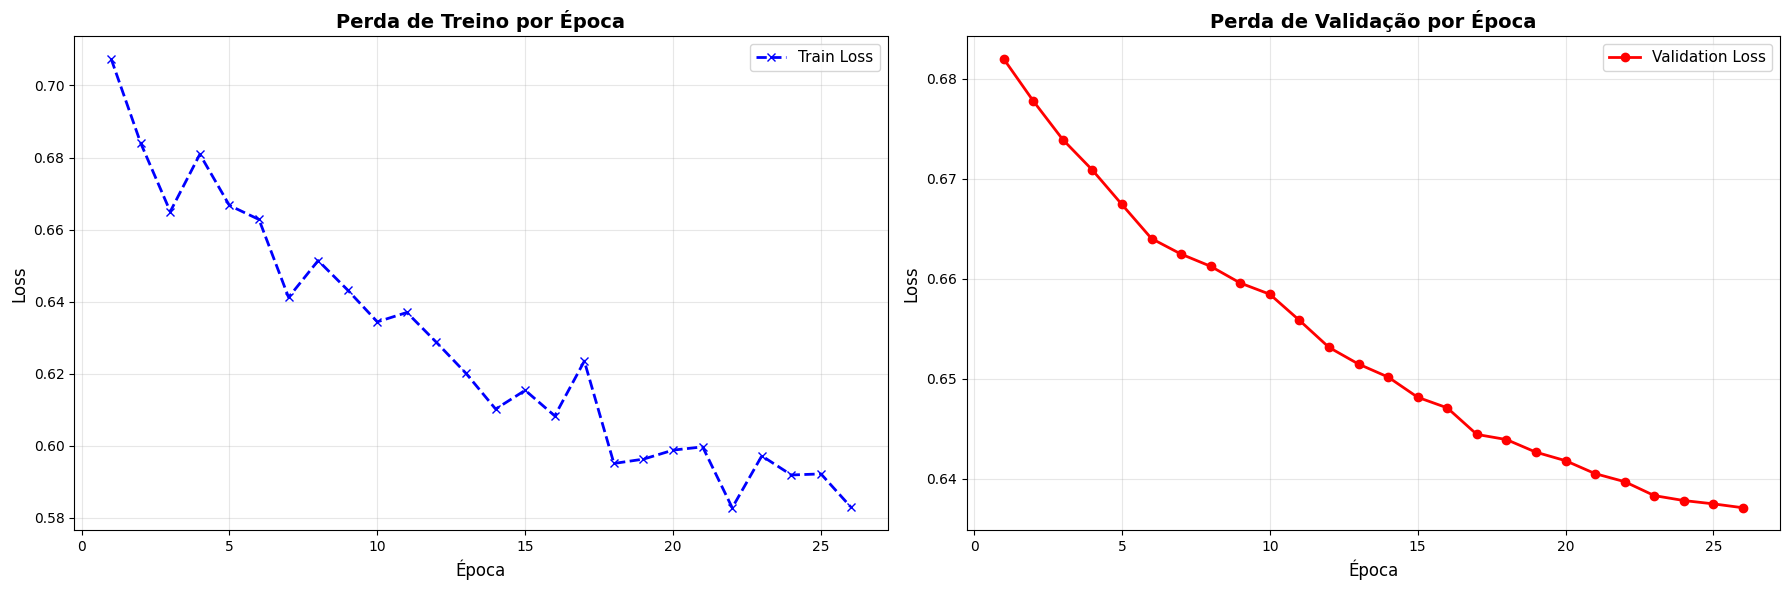


✅ TREINAMENTO CONCLUÍDO COM SUCESSO!


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import Dataset as TorchDataset

# Listas para armazenar métricas para plotagem
train_losses_plot, val_losses_plot = [], []
train_accuracies_plot, val_accuracies_plot = [], []

# ---------------------------------------------------------------------
# Configuração dos argumentos de treinamento
training_args = TrainingArguments(
    output_dir="./bertimbau-denuncias",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,
    num_train_epochs=30,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs",
    disable_tqdm=False,
    report_to="none",
    fp16=True,
    seed=42,
    gradient_accumulation_steps=1,
    remove_unused_columns=True,
    label_names=["labels"]
)

# Data Collator para padding dinâmico
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Custom Dataset (para trabalhar com DataFrames)
class CustomDataset(TorchDataset):
    def __init__(self, encodings, labels):
        self.encodings = {key: torch.tensor(val) for key, val in encodings.items()}
        self.labels = torch.tensor(labels.values if isinstance(labels, pd.Series) else labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Criar datasets
print("\n📊 Preparando datasets...")
train_dataset = CustomDataset(train_encodings, train_df['classe'].map(label2id).tolist())
val_dataset = CustomDataset(val_encodings, val_df['classe'].map(label2id).tolist())
test_dataset = CustomDataset(test_encodings, test_df['classe'].map(label2id).tolist())

print(f"✅ Datasets criados:")
print(f"   • Treino: {len(train_dataset)} amostras")
print(f"   • Validação: {len(val_dataset)} amostras")
print(f"   • Teste: {len(test_dataset)} amostras")

# Instanciar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=1e-3)],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

try:
    print("\n" + "="*80)
    print("🚀 INICIANDO TREINAMENTO")
    print("="*80 + "\n")

    # Treinar o modelo
    train_results = trainer.train()

    # --- EXTRAIR MÉTRICAS DOS LOGS PARA OS GRÁFICOS ---
    print("\n📊 Coletando métricas de treinamento...")
    logs = trainer.state.log_history

    # Limpar listas (caso esteja rodando múltiplas vezes)
    train_losses_plot = []
    val_losses_plot = []
    train_accuracies_plot = []
    val_accuracies_plot = []

    # Iterar sobre os logs para preencher as listas
    for log_entry in logs:
        # Perdas de Treino: o 'loss' é logado para o treinamento
        if 'loss' in log_entry and 'eval_loss' not in log_entry:
            train_losses_plot.append(log_entry['loss'])

        # Métricas de Validação: logadas com prefixo 'eval_'
        if 'eval_loss' in log_entry and 'eval_accuracy' in log_entry:
            val_losses_plot.append(log_entry['eval_loss'])
            val_accuracies_plot.append(log_entry['eval_accuracy'])

    # Diagnóstico
    print(f"\n📊 Métricas coletadas:")
    print(f"   • Train losses: {len(train_losses_plot)} épocas")
    print(f"   • Validation losses: {len(val_losses_plot)} épocas")
    print(f"   • Validation accuracies: {len(val_accuracies_plot)} épocas")

    # ⚠️ GARANTIR MESMO TAMANHO
    min_length = min(len(train_losses_plot), len(val_losses_plot))
    if len(train_losses_plot) != len(val_losses_plot):
        print(f"   ⚠️ AVISO: Tamanhos diferentes! Ajustando para {min_length} épocas")
        train_losses_plot = train_losses_plot[:min_length]
        val_losses_plot = val_losses_plot[:min_length]
        val_accuracies_plot = val_accuracies_plot[:min_length]

    # Métricas finais de treino
    print(f"\n📊 Métricas finais de treino:")
    print(f"   Loss: {train_results.metrics.get('train_loss', 'N/A'):.4f}")
    print(f"   Tempo total: {train_results.metrics.get('train_runtime', 'N/A'):.2f}s")

    # ✅ CALCULAR TRAIN ACCURACY
    print(f"\n📊 Calculando Train Accuracy...")
    train_predictions_output = trainer.predict(train_dataset)
    train_predictions = np.argmax(train_predictions_output.predictions, axis=1)
    train_labels_array = train_predictions_output.label_ids
    train_accuracy_final = (train_predictions == train_labels_array).mean()
    print(f"   Train Accuracy: {train_accuracy_final:.4f}")

    # Avaliação no conjunto de VALIDAÇÃO
    print(f"\n🔍 Avaliação no conjunto de VALIDAÇÃO...")
    val_metrics = trainer.evaluate(val_dataset)
    print(f"   Resultados de validação:")
    for key, value in val_metrics.items():
        print(f"      • {key}: {value:.4f}")

    # ✅ CALCULAR GAP
    final_train_loss = train_results.metrics.get('train_loss', 0)
    final_val_loss = val_metrics.get('eval_loss', 0)
    gap = final_val_loss - final_train_loss
    gap_pct = (gap / final_train_loss) * 100 if final_train_loss > 0 else 0

    print(f"\n📏 Análise de GAP:")
    print(f"   Train Loss: {final_train_loss:.6f}")
    print(f"   Val Loss: {final_val_loss:.6f}")
    print(f"   GAP: {gap:.6f} ({gap_pct:.2f}%)")
    if gap < 0.10:
        print(f"   Status: ✅ Bom")
    elif gap < 0.15:
        print(f"   Status: ⚠️ Atenção")
    else:
        print(f"   Status: 🚨 Overfitting")

    # --- 📊 GRÁFICOS DE COMPARAÇÃO POR ÉPOCA ---
    print(f"\n📊 Gerando gráficos...")

    epochs_completed = min_length
    epochs_to_plot = list(range(1, epochs_completed + 1))

    if not epochs_to_plot:
        print("\n⚠️ Não há dados suficientes para gerar os gráficos.")
    else:
        # --- GRÁFICO: Loss por Época (Treino vs Validação) ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

        # Subplot 1: Train Loss
        ax1.plot(epochs_to_plot, train_losses_plot,
                 marker='x', linestyle='--', linewidth=2, markersize=6,
                 color='blue', label='Train Loss')
        ax1.set_xlabel("Época", fontsize=12)
        ax1.set_ylabel("Loss", fontsize=12)
        ax1.set_title("Perda de Treino por Época", fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)

        # Subplot 2: Validation Loss
        ax2.plot(epochs_to_plot, val_losses_plot,
                 marker='o', linestyle='-', linewidth=2, markersize=6,
                 color='red', label='Validation Loss')
        ax2.set_xlabel("Época", fontsize=12)
        ax2.set_ylabel("Loss", fontsize=12)
        ax2.set_title("Perda de Validação por Época", fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    print("\n" + "="*80)
    print("✅ TREINAMENTO CONCLUÍDO COM SUCESSO!")
    print("="*80)

except Exception as e:
    import traceback
    print(f"\n❌ Erro durante o treinamento ou avaliação:")
    print(traceback.format_exc())

# **6. AVALIAÇÃO FINAL NO TESTE**

In [ ]:
print("\n\n==================== RESULTADOS FINAIS DO MODELO ====================")
print("\nAvaliação no conjunto de teste:")

test_results = trainer.predict(test_dataset)
final_metrics = test_results.metrics

for metric, value in final_metrics.items():
    print(f"{metric}: {value}")



==================== RESULTADOS FINAIS DO MODELO ====================

Avaliação no conjunto de teste:


test_loss: 0.580078125
test_accuracy: 0.6923
test_auc: 0.8047
test_f1_invasao: 0.6923
test_f1_violencia: 0.6923
test_precision_invasao: 0.6923
test_precision_violencia: 0.6923
test_recall_invasao: 0.6923
test_recall_violencia: 0.6923
test_precision_macro: 0.6923
test_recall_macro: 0.6923
test_f1_macro: 0.6923
test_runtime: 0.1241
test_samples_per_second: 209.494
test_steps_per_second: 32.23


# **7. SALVAR MODELO E DADOS DE RESULTADOS**

In [ ]:
model.save_pretrained("/content/drive/MyDrive/2025/tcc-final/resultados/modelo_bertimbau_final")
tokenizer.save_pretrained("/content/drive/MyDrive/2025/tcc-final/resultados/modelo_bertimbau_final")
print("Modelo salvo no Google Drive!")

# Salvar resultados do treinamento e rótulos/previsões finais
output_results_path = "/content/drive/MyDrive/2025/tcc-final/resultados/resultados_fine_tuning.xlsx"

# Get the predictions from the test_results object
predictions = np.argmax(test_results.predictions, axis=1)


# Criar um DataFrame para os resultados de teste
results_df = pd.DataFrame({
    'texto': test_df['texto'],
    'rotulo_verdadeiro': test_df['classe'],
    'rotulo_predito_id': predictions,
    'rotulo_predito': [id2label[p] for p in predictions]
})

# Salvar o DataFrame de resultados em um arquivo Excel
results_df.to_excel(output_results_path, index=False)
print(f"Resultados de teste (texto, rótulo verdadeiro, rótulo predito) salvos em: {output_results_path}")

# Salvar as métricas finais em um arquivo de texto ou CSV
metrics_output_path = "/content/drive/MyDrive/2025/tcc-final/resultados/metricas_finais.txt"
with open(metrics_output_path, 'w') as f:
    f.write("Métricas Finais da Avaliação no Conjunto de Teste:\n")
    for metric_name, value in final_metrics.items():
        f.write(f"{metric_name}: {value:.4f}\n")
print(f"Métricas finais salvas em: {metrics_output_path}")

# --- FIM DO CONTADOR DE TEMPO ---
end_total_time = time.time()
total_execution_time = end_total_time - start_total_time
print(f"\nTempo total de execução do script: {total_execution_time:.2f} segundos")

Modelo salvo no Google Drive!
Resultados de teste (texto, rótulo verdadeiro, rótulo predito) salvos em: /content/drive/MyDrive/2025/tcc-final/resultados/resultados_fine_tuning.xlsx
Métricas finais salvas em: /content/drive/MyDrive/2025/tcc-final/resultados/metricas_finais.txt

Tempo total de execução do script: 429.71 segundos
